## Drug Classification Machine Learning Example for Digital Lincoln
This Jupyter Notebook provides a full, end-to-end worked example for constructing a machine learning model from scratch.

The data is fictitious and is provided under an open source license from Kaggle - https://www.kaggle.com/abohelal/random-forest-99-accuracy-knn-96-accuracy/data.

The example is built around a decision tree classification algorithm which uses a set of data on drug recommendations to build the ability to presrcribe drugs for new patients that were not present in the data and that the model has never encountered before.

The exmaple strives to explain and demonstrate how predictive models can be built by providing all the programme code and by making that code as straightforward as possible.

The code is developed in the Python programming language and makes extensive use of the scikit-learn library to provide the underlying implementation of the decision tree classifier.

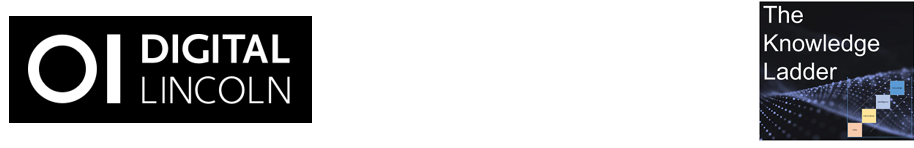

### 1. Import Libraries
To start the project a number of standard libraries need to be imported ...

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
#from dtreeviz.trees import dtreeviz
import dtreeviz

import sys
sys.path.insert(1, r"C:\Users\GHarr\OneDrive - Lincoln College\Python Projects\Data Science\Utilities")

from classification_tools import plot_confusion_matrix  # type:ignore

import warnings
warnings.filterwarnings('ignore')

### 2. Read the Data
The next stage is to use a library called "Pandas" to read the data in and then to take a peek at what the data looks like ...

In [38]:
#df_drug = pd.read_csv("drug200.csv")

#np.random.seed(42)
#num_rows_to_change = int(0.05 * len(df_drug))

#random_indices = np.random.choice(df_drug.index, num_rows_to_change, replace=False)
#df_drug.loc[random_indices, 'Na_to_K'] = df_drug.loc[random_indices, 'Na_to_K'] * 1000

#random_indices = np.random.choice(df_drug.index, num_rows_to_change, replace=False)
#df_drug.loc[random_indices, 'Na_to_K'] = np.nan

#random_indices = np.random.choice(df_drug.index, num_rows_to_change, replace=False)
#df_drug.loc[random_indices, 'Sex'] = "XXXX"

#df_drug.to_csv("drug200 v2.csv")

In [39]:
df_drug = pd.read_csv("drug200 v2.csv")

### 3. Exploratory Data Analysis (EDA)
A common next step is to explore the data to form a good understnading of it to inform the cleaning, preparation and modelling stages ...

In [40]:
df_drug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   200 non-null    int64  
 1   Age          200 non-null    int64  
 2   Sex          200 non-null    object 
 3   BP           200 non-null    object 
 4   Cholesterol  200 non-null    object 
 5   Na_to_K      190 non-null    float64
 6   Drug         200 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 11.1+ KB


What do you notice about the immediate analysis of this dataset?

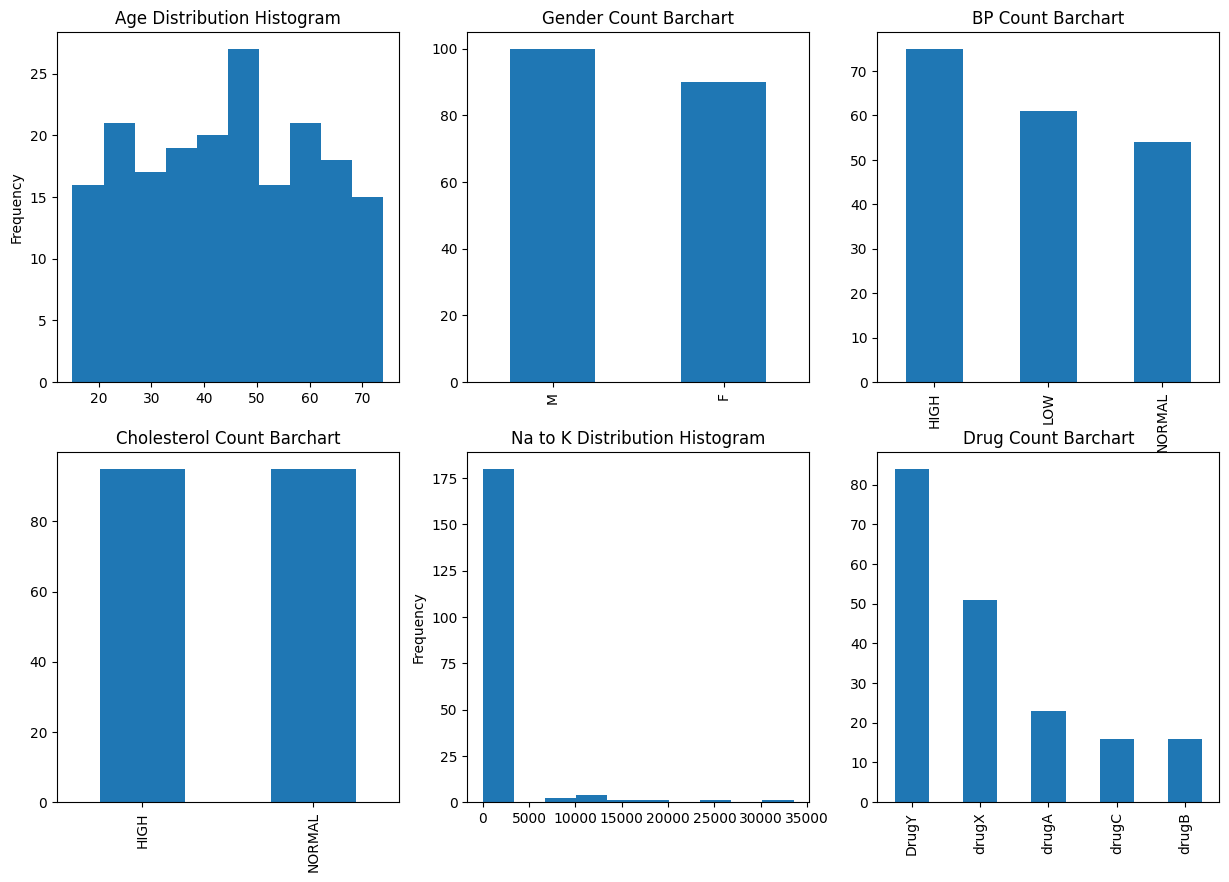

In [58]:
fig, axes = plt.subplots(2, 3)
df_drug["Age"].plot.hist(ax=axes[0,0], figsize=(15, 10), title="Age Distribution Histogram")
df_drug["Sex"].value_counts().plot.bar(ax=axes[0,1], title="Gender Count Barchart")
df_drug["BP"].value_counts().plot.bar(ax=axes[0,2], title="BP Count Barchart")
df_drug["Cholesterol"].value_counts().plot.bar(ax=axes[1,0], title="Cholesterol Count Barchart")
df_drug["Na_to_K"].plot.hist(ax=axes[1,1], title="Na to K Distribution Histogram")
df_drug["Drug"].value_counts().plot.bar(ax=axes[1,2], title="Drug Count Barchart")
plt.show()

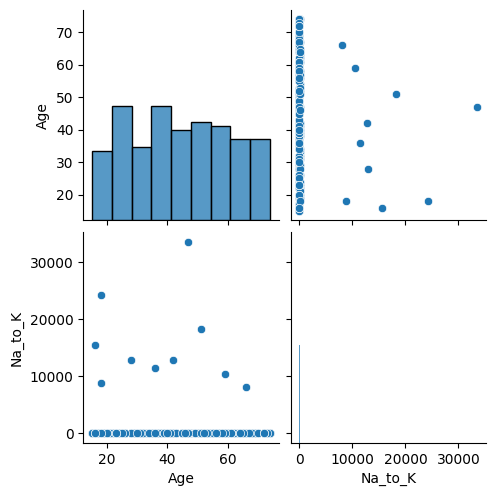

In [30]:
sns.pairplot(df_drug, diag_kind='hist', markers='o', height=2.5)
plt.show()

### 4. Data Cleaning
The objective of data cleaning is to prepare the data for modeling and predictions. 

Data must all be converted into numbers and also not contain any unusual values as this will skew the predictions.

Any unusual values must be dealt with but it is important to keep as many rows as possible because the more rows we keep the more accurate predictions made on that data are likely to be.

#### 4.1 Resolve nonsensical values in the "Sex" column

In [44]:
df_drug["Sex"].value_counts()

M       100
F        90
XXXX     10
Name: Sex, dtype: int64

The "Sex" data column contains 10 rows with "XXXX". It is reasonable to assume that this data has been mis-keyed or the value is unknown and if sex / gender is an important feature in the prediction we will need to deal with this by deleting the rows ...

In [47]:
drop_XXXX_filter = df_drug["Sex"] == "XXXX"

df_drug.drop(df_drug[drop_XXXX_filter].index, inplace=True)
df_drug.reset_index(drop=True, inplace=True)

M    100
F     90
Name: Sex, dtype: int64

In [49]:
df_drug["Sex"].value_counts()

M    100
F     90
Name: Sex, dtype: int64

In [50]:
df_drug

,Unnamed: 0,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,0,23,F,HIGH,HIGH,25.355,DrugY
1,1,47,M,LOW,HIGH,13.093,drugC
2,2,47,M,LOW,HIGH,10.114,drugC
3,3,28,F,NORMAL,HIGH,7.798,drugX
4,4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...,...
185,195,56,F,LOW,HIGH,11.567,drugC
186,196,16,M,LOW,HIGH,12.006,drugC
187,197,52,M,NORMAL,HIGH,9.894,drugX
188,198,23,M,NORMAL,NORMAL,14.020,drugX


#### 4.2 Deal with Null values in ``Na_to_K``
One approach would be to simply get rid of all rows where there is a null value in this column ...

In [52]:
df_drug_drop = df_drug.dropna(subset=['Na_to_K'])
df_drug_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 189
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   180 non-null    int64  
 1   Age          180 non-null    int64  
 2   Sex          180 non-null    object 
 3   BP           180 non-null    object 
 4   Cholesterol  180 non-null    object 
 5   Na_to_K      180 non-null    float64
 6   Drug         180 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 11.2+ KB


... but what effect might this have on the eventual predictions?

In [53]:
df_drug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   190 non-null    int64  
 1   Age          190 non-null    int64  
 2   Sex          190 non-null    object 
 3   BP           190 non-null    object 
 4   Cholesterol  190 non-null    object 
 5   Na_to_K      180 non-null    float64
 6   Drug         190 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 10.5+ KB


Another approach (for continuous numbers) is to replace all null values with the mean (or average) value ...

In [54]:
mean_na_to_k = df_drug['Na_to_K'].mean()
df_drug['Na_to_K'].fillna(mean_na_to_k, inplace=True)

df_drug.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   190 non-null    int64  
 1   Age          190 non-null    int64  
 2   Sex          190 non-null    object 
 3   BP           190 non-null    object 
 4   Cholesterol  190 non-null    object 
 5   Na_to_K      190 non-null    float64
 6   Drug         190 non-null    object 
dtypes: float64(1), int64(2), object(4)
memory usage: 10.5+ KB


#### 4.3 Removing Outliers
Is there anything strange about the ``Na_to_K`` data ...

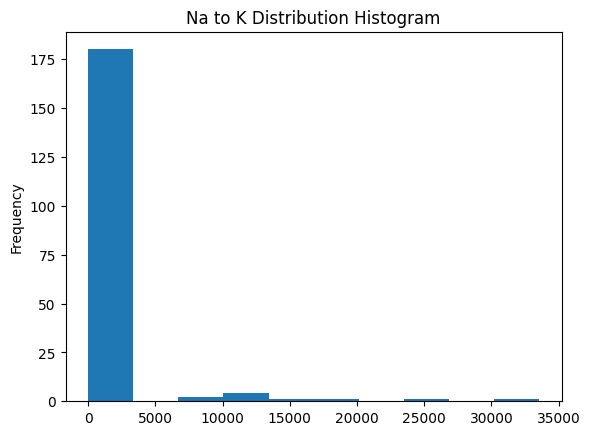

In [59]:
df_drug["Na_to_K"].plot.hist(title="Na to K Distribution Histogram")
plt.show()

This pattern strongly suggests that this data contains "outliers" - strange values that are either much bigger or much smaller than the majority of the data.

Outliers can be identified by applying a statistical formula looking for 1.5 times the inter-quartile range.

Again we can choose to delete / remove rows or to replace them with the mean value ...

In [60]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
        
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

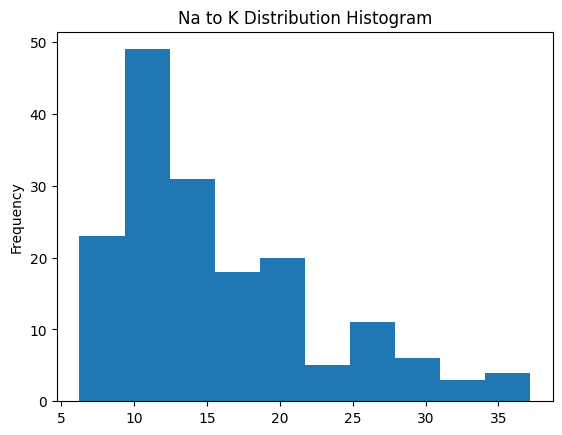

In [61]:
df_drug = remove_outlier(df_drug, "Na_to_K")

df_drug["Na_to_K"].plot.hist(title="Na to K Distribution Histogram")
plt.show()

### 5. Preparing the Data for Modeling
#### 5.1 Preparing Categorical Feature
The next step is to prepare the categorical data for modeling. In this example the "categorical" features (those that contain textual values like "HIGH" and "NORMAL" must be converted into numbers because most machine learning algorithms cannot deal with text until it has been converted into a numerical equivalent ...

In [5]:
categorical_features = list(df_drug.select_dtypes(include="object").columns)

label_encoders = dict()

for feature in categorical_features:
    le = LabelEncoder()
    df_drug[feature]=le.fit_transform(df_drug[feature])
    label_encoders[feature] = le
    
df_drug.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,0
1,47,1,1,0,13.093,3
2,47,1,1,0,10.114,3
3,28,0,2,0,7.798,4
4,61,0,1,0,18.043,0


What 

At this stage the data is also split into X (the "features" used to make a prediction) and y (the "target" which is going to be predicted by the model) ...

In [6]:
X = df_drug.drop("Drug", axis=1)
y = df_drug["Drug"]

### 5. Choose and Evaluate a Machine Learning Model
This example has selected a decision tree classifier as the basis for the model.

It has also used a technique called cross-fold validation to evaluate the performance of the model (as opposed to a single "train / test split") ...

In [7]:
model = DecisionTreeClassifier(criterion="entropy")

kfold = KFold(random_state=42, n_splits=5, shuffle=True)
cv_results = cross_val_score(model, X, y, cv=kfold, scoring="accuracy", verbose=1)
print(cv_results.mean(), cv_results.std())

0.99 0.012247448713915901


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


### 6. Hyper Parameter Tuning
The first attempt got a suspiciously high accuracy score of 99%! 

The likely cause is a model that suffers from "over-fitting" i.e. it performs very well against the training and test data but accuracy significantly degrades when it encounters new, real-world data that it has not seen before.

Decision tress suffer from over-fitting when they are allowed to become too deep. It is actually better to restrict the depth of the tree which is likely to reduce accuracy in testing and testing but significantly improve performance in the real world.

Making these types of changes to a model's parameters is called "hyper-parameter tuning".

This time the decision tree is restricted to a ``max_depth`` of 3 effectively "pruning" the tree beyond that depth ...

In [8]:
model = DecisionTreeClassifier(criterion="entropy", max_depth=3)

The accuracy is re-evaluated and this time is is 86% which is less suspicious and more likely to perform well againt production data.

In [9]:
kfold = KFold(random_state=42, n_splits=5, shuffle=True)
cv_results = cross_val_score(model, X, y, cv=kfold, scoring="accuracy", verbose=1)
print(cv_results.mean(), cv_results.std())

0.86 0.02999999999999998


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


Another technique used to evaluate performance is to fold the data and to repatedly re-train and re-evaluate the model ...

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


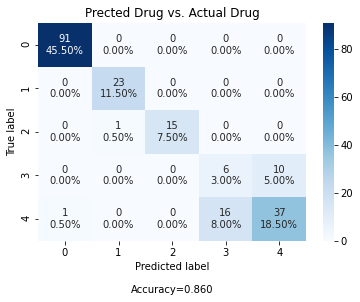

In [10]:
y_predict = cross_val_predict(model, X, y, cv=kfold, verbose=10, method="predict")
plot_confusion_matrix(y, y_predict, f"Prected Drug vs. Actual Drug", cmap="Blues")

### 7. Train the Model
Once a model has been selected, tuned and evaluated the next stage is to "fit" or "train" the model / algorithm using the training features (X) and training target (y). 

This is equivalent to the ML library code creating a model that best fits the data that has been presented ...

In [11]:
model.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

### 8. Visualising the Trained Model
Many libraries exist to provide simple visualisations for what has happened inside the ``.fit()`` method. 

In this case the model has build an internal tree-structure representing successive splits of the data that maximise the "purity" of the two new sub-sets of data ...

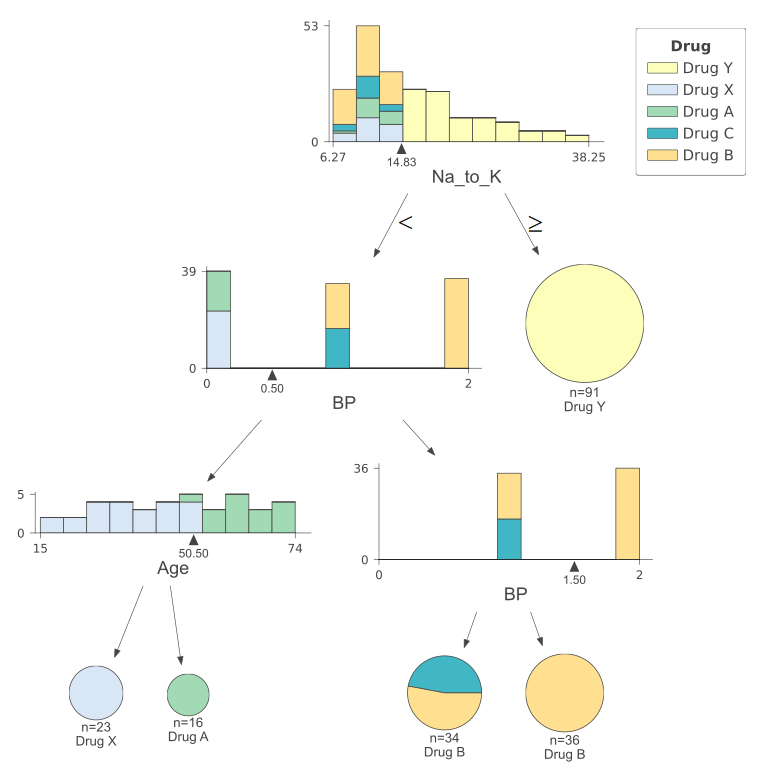

In [12]:
viz = dtreeviz(model, X, y, target_name='Drug', feature_names=X.columns.to_list(), class_names=["Drug Y", "Drug X", "Drug A", "Drug C", "Drug B"], scale=2.0)
viz.save("dtreeviz.svg")
viz 

### 9. Use the Model to Make Predictions for New Data
The fitted / trained machine learning algorithm can now be used to make predictions. The code below accepts age, sex, bp, cholesterol and Na to K as parameters and calls the model to make a prediction.

The prediction is very straight-forward -

```
model.predict(df_predict)
```

The only complexity is that the English readable input parameters (like "M" = "Male") have to be converted into numbers using exactly the same encoding mechanism that was used to train the model.

The drug will be predicted as a number (0, 1, 2 or 3) and this has to be reverse encoded back into an English-readable drug description ...

In [13]:
def predict_drug(age, sex, bp, cholesterol, Na_to_K):
    sex_ = label_encoders["Sex"].transform([sex])[0]
    bp_ = label_encoders["BP"].transform([bp])[0]
    cholesterol_ = label_encoders["Cholesterol"].transform([cholesterol])[0]
    
    df_predict = pd.DataFrame([[age, sex_, bp_, cholesterol_, Na_to_K]], columns=['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K'])
    
    drug = label_encoders["Drug"].inverse_transform([model.predict(df_predict)[0]])[0]
    
    print(f"For a patient with age {age}, gender {sex}, bp {bp}, cholesterol {cholesterol} and NA to K {Na_to_K:.02f} the prescribed drug is {drug}")

Having completed all the steps above it is simply a matter of calling ``predict_drug`` with a set of parameters for each patient and the machine learning algorithm will provide a probabilistic prediction of the correct drug to prescribe based on what it learned from the data that was used to train it ...

In [14]:
predict_drug(age=23, sex="F", bp="HIGH", cholesterol="HIGH", Na_to_K=25.355)
predict_drug(age=47, sex="M", bp="LOW", cholesterol="HIGH", Na_to_K=13.093)
predict_drug(age=48, sex="F", bp="NORMAL", cholesterol="HIGH", Na_to_K=7.798)
predict_drug(age=53, sex="M", bp="NORMAL", cholesterol="NORMAL", Na_to_K=df_drug["Na_to_K"].mean())

For a patient with age 23, gender F, bp HIGH, cholesterol HIGH and NA to K 25.36 the prescribed drug is DrugY
For a patient with age 47, gender M, bp LOW, cholesterol HIGH and NA to K 13.09 the prescribed drug is drugX
For a patient with age 48, gender F, bp NORMAL, cholesterol HIGH and NA to K 7.80 the prescribed drug is drugX
For a patient with age 53, gender M, bp NORMAL, cholesterol NORMAL and NA to K 16.08 the prescribed drug is DrugY
